<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Data Cleaning

In [2]:
# frequently used python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Order Dataset

In [3]:
order_df = pd.read_csv('olist_orders_dataset.csv')
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null object
order_approved_at                99281 non-null object
order_delivered_carrier_date     97658 non-null object
order_delivered_customer_date    96476 non-null object
order_estimated_delivery_date    99441 non-null object
dtypes: object(8)
memory usage: 6.1+ MB


In [4]:
order_df[order_df.duplicated()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date


In [5]:
order_df.drop(['order_status',
               'order_delivered_carrier_date',
               'order_approved_at',
               'order_purchase_timestamp'], axis='columns', inplace=True)

from datetime import datetime, date
for column in ['order_delivered_customer_date', 'order_estimated_delivery_date']:
    order_df[column] = pd.to_datetime(order_df[column])
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_delivered_customer_date    96476 non-null datetime64[ns]
order_estimated_delivery_date    99441 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 3.0+ MB


In [6]:
order_df.head()

,order_id,customer_id,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-16 18:17:02,2018-02-26


## Customer Dataset

In [7]:
customer_df = pd.read_csv('olist_customers_dataset.csv')
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [8]:
customer_df[customer_df.duplicated()]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


In [9]:
customer_df.drop(['customer_zip_code_prefix', 'customer_city'], axis='columns', inplace=True)

In [10]:
customer_df.nunique()

customer_id           99441
customer_unique_id    96096
customer_state           27
dtype: int64

In [11]:
customer_df.head()

,customer_id,customer_unique_id,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP


## Payment Dataset

In [12]:
payment_df = pd.read_csv('olist_order_payments_dataset.csv')
payment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
order_id                103886 non-null object
payment_sequential      103886 non-null int64
payment_type            103886 non-null object
payment_installments    103886 non-null int64
payment_value           103886 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [13]:
payment_df.order_id.nunique()

99440

In [14]:
payment_df[payment_df.duplicated()]

,order_id,payment_sequential,payment_type,payment_installments,payment_value


In [15]:
payment_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [16]:
payment_df.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


In [17]:
payment_df.nunique()

order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

## Review Dataset

In [18]:
review_df = pd.read_csv('olist_order_reviews_dataset.csv')
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
review_id                  100000 non-null object
order_id                   100000 non-null object
review_score               100000 non-null int64
review_comment_title       11715 non-null object
review_comment_message     41753 non-null object
review_creation_date       100000 non-null object
review_answer_timestamp    100000 non-null object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [19]:
review_df[review_df.duplicated()]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp


In [20]:
review_df.drop(['review_id', 'review_creation_date', 'review_answer_timestamp'], axis='columns', inplace=True)
review_df.columns

Index(['order_id', 'review_score', 'review_comment_title',
       'review_comment_message'],
      dtype='object')

In [21]:
for columns in ['review_comment_title', 'review_comment_message']:
    # replace present values with 1
    review_df.loc[review_df[columns].notnull(), columns] = 1
    # replace null values with 0
    review_df.loc[review_df[columns].isna(), columns] = 0
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
order_id                  100000 non-null object
review_score              100000 non-null int64
review_comment_title      100000 non-null int64
review_comment_message    100000 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.1+ MB


In [22]:
review_df.head()

,order_id,review_score,review_comment_title,review_comment_message
0,73fc7af87114b39712e6da79b0a377eb,4,0,0
1,a548910a1c6147796b98fdf73dbeba33,5,0,0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0
3,658677c97b385a9be170737859d3511b,5,0,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,1


## Item Dataset

In [23]:
item_df = pd.read_csv('olist_order_items_dataset.csv')

In [24]:
item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
order_id               112650 non-null object
order_item_id          112650 non-null int64
product_id             112650 non-null object
seller_id              112650 non-null object
shipping_limit_date    112650 non-null object
price                  112650 non-null float64
freight_value          112650 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [25]:
item_df[item_df.duplicated()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [26]:
'''
item_df.drop(['seller_id',
              'shipping_limit_date',
              'price',
              'freight_value',
              'order_item_id'], axis='columns', inplace=True)
item_df.columns
'''

"\nitem_df.drop(['seller_id',\n              'shipping_limit_date',\n              'price',\n              'freight_value',\n              'order_item_id'], axis='columns', inplace=True)\nitem_df.columns\n"

In [27]:
item_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [28]:
item_df.order_id.nunique()

98666

## Product Dataset

In [29]:
product_df = pd.read_csv('olist_products_dataset.csv')

In [30]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
product_id                    32951 non-null object
product_category_name         32341 non-null object
product_name_lenght           32341 non-null float64
product_description_lenght    32341 non-null float64
product_photos_qty            32341 non-null float64
product_weight_g              32949 non-null float64
product_length_cm             32949 non-null float64
product_height_cm             32949 non-null float64
product_width_cm              32949 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [31]:
product_df[product_df.duplicated()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm


In [32]:
'''
product_df.drop(['product_name_lenght',
                 'product_description_lenght', 
                 'product_photos_qty', 
                 'product_weight_g',
                 'product_length_cm',
                 'product_height_cm',
                 'product_width_cm'], axis='columns', inplace=True)
'''

"\nproduct_df.drop(['product_name_lenght',\n                 'product_description_lenght', \n                 'product_photos_qty', \n                 'product_weight_g',\n                 'product_length_cm',\n                 'product_height_cm',\n                 'product_width_cm'], axis='columns', inplace=True)\n"

In [33]:
product_df.fillna(product_df.median(), inplace=True)
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
product_id                    32951 non-null object
product_category_name         32341 non-null object
product_name_lenght           32951 non-null float64
product_description_lenght    32951 non-null float64
product_photos_qty            32951 non-null float64
product_weight_g              32951 non-null float64
product_length_cm             32951 non-null float64
product_height_cm             32951 non-null float64
product_width_cm              32951 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [34]:
product_df.fillna('other', inplace=True)
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
product_id                    32951 non-null object
product_category_name         32951 non-null object
product_name_lenght           32951 non-null float64
product_description_lenght    32951 non-null float64
product_photos_qty            32951 non-null float64
product_weight_g              32951 non-null float64
product_length_cm             32951 non-null float64
product_height_cm             32951 non-null float64
product_width_cm              32951 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [35]:
product_df.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [36]:
product_df.product_category_name.nunique()

74

## Translation Dataset

In [37]:
translation_df = pd.read_csv('product_category_name_translation.csv')
translation_df.info()
translation_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
product_category_name            71 non-null object
product_category_name_english    71 non-null object
dtypes: object(2)
memory usage: 1.2+ KB


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


## Seller Dataset

In [38]:
seller_df = pd.read_csv('olist_sellers_dataset.csv')
seller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
seller_id                 3095 non-null object
seller_zip_code_prefix    3095 non-null int64
seller_city               3095 non-null object
seller_state              3095 non-null object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [39]:
seller_df.drop(['seller_zip_code_prefix', 'seller_city'], axis='columns', inplace=True)
seller_df.columns

Index(['seller_id', 'seller_state'], dtype='object')

## Database Joins

In [40]:
ro_df = pd.merge(review_df, order_df, how='left', on='order_id')
ro_df.info()
ro_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
order_id                         100000 non-null object
review_score                     100000 non-null int64
review_comment_title             100000 non-null int64
review_comment_message           100000 non-null int64
customer_id                      100000 non-null object
order_delivered_customer_date    97013 non-null datetime64[ns]
order_estimated_delivery_date    100000 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 6.1+ MB


,order_id,review_score,review_comment_title,review_comment_message,customer_id,order_delivered_customer_date,order_estimated_delivery_date
0,73fc7af87114b39712e6da79b0a377eb,4,0,0,41dcb106f807e993532d446263290104,2018-01-17 18:42:41,2018-02-02
1,a548910a1c6147796b98fdf73dbeba33,5,0,0,8a2e7ef9053dea531e4dc76bd6d853e6,2018-03-09 23:17:20,2018-03-14
2,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,e226dfed6544df5b7b87a48208690feb,2018-02-16 17:28:48,2018-03-09
3,658677c97b385a9be170737859d3511b,5,0,1,de6dff97e5f1ba84a3cd9a3bc97df5f6,2017-04-20 09:08:35,2017-05-10
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,1,5986b333ca0d44534a156a52a8e33a83,2018-02-28 16:33:35,2018-03-09


In [41]:
roc_df = pd.merge(ro_df, customer_df, how='left', on='customer_id')
roc_df.drop(['customer_id', 'customer_unique_id'], axis='columns', inplace=True)
roc_df.info()
roc_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 7 columns):
order_id                         100000 non-null object
review_score                     100000 non-null int64
review_comment_title             100000 non-null int64
review_comment_message           100000 non-null int64
order_delivered_customer_date    97013 non-null datetime64[ns]
order_estimated_delivery_date    100000 non-null datetime64[ns]
customer_state                   100000 non-null object
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 6.1+ MB


,order_id,review_score,review_comment_title,review_comment_message,order_delivered_customer_date,order_estimated_delivery_date,customer_state
0,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-17 18:42:41,2018-02-02,SP
1,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-09 23:17:20,2018-03-14,SP
2,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,2018-02-16 17:28:48,2018-03-09,BA
3,658677c97b385a9be170737859d3511b,5,0,1,2017-04-20 09:08:35,2017-05-10,SC
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,1,2018-02-28 16:33:35,2018-03-09,SC


In [42]:
rocp_df = pd.merge(roc_df, payment_df, on='order_id')
rocp_df.drop('payment_sequential', axis='columns', inplace=True)
rocp_df.info()
rocp_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104485 entries, 0 to 104484
Data columns (total 10 columns):
order_id                         104485 non-null object
review_score                     104485 non-null int64
review_comment_title             104485 non-null int64
review_comment_message           104485 non-null int64
order_delivered_customer_date    101331 non-null datetime64[ns]
order_estimated_delivery_date    104485 non-null datetime64[ns]
customer_state                   104485 non-null object
payment_type                     104485 non-null object
payment_installments             104485 non-null int64
payment_value                    104485 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 8.8+ MB


,order_id,review_score,review_comment_title,review_comment_message,order_delivered_customer_date,order_estimated_delivery_date,customer_state,payment_type,payment_installments,payment_value
0,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-17 18:42:41,2018-02-02,SP,credit_card,8,397.26
1,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-09 23:17:20,2018-03-14,SP,credit_card,1,88.09
2,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,2018-02-16 17:28:48,2018-03-09,BA,credit_card,1,194.12
3,658677c97b385a9be170737859d3511b,5,0,1,2017-04-20 09:08:35,2017-05-10,SC,credit_card,1,222.84
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,0,1,2018-02-28 16:33:35,2018-03-09,SC,credit_card,10,1333.25


In [43]:
rocpi_df = pd.merge(rocp_df, item_df, on='order_id')
rocpi_df.drop(['shipping_limit_date', 'order_item_id'], axis='columns', inplace=True)
rocpi_df.info()
rocpi_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 14 columns):
order_id                         118315 non-null object
review_score                     118315 non-null int64
review_comment_title             118315 non-null int64
review_comment_message           118315 non-null int64
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_state                   118315 non-null object
payment_type                     118315 non-null object
payment_installments             118315 non-null int64
payment_value                    118315 non-null float64
product_id                       118315 non-null object
seller_id                        118315 non-null object
price                            118315 non-null float64
freight_value                    118315 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(4), object(5)
memory usage: 13.5+ MB


,order_id,review_score,review_comment_title,review_comment_message,order_delivered_customer_date,order_estimated_delivery_date,customer_state,payment_type,payment_installments,payment_value,product_id,seller_id,price,freight_value
0,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-17 18:42:41,2018-02-02,SP,credit_card,8,397.26,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,185.00,13.63
1,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-17 18:42:41,2018-02-02,SP,credit_card,8,397.26,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,185.00,13.63
2,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-09 23:17:20,2018-03-14,SP,credit_card,1,88.09,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,79.79,8.30
3,f9e4b658b201a9f2ecdecbb34bed034b,5,0,0,2018-02-16 17:28:48,2018-03-09,BA,credit_card,1,194.12,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,149.00,45.12
4,658677c97b385a9be170737859d3511b,5,0,1,2017-04-20 09:08:35,2017-05-10,SC,credit_card,1,222.84,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,179.99,42.85


In [44]:
rocpip_df = pd.merge(rocpi_df, product_df, on='product_id')
rocpip_df.drop('product_id', axis='columns', inplace=True)
rocpip_df.info()
rocpip_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 21 columns):
order_id                         118315 non-null object
review_score                     118315 non-null int64
review_comment_title             118315 non-null int64
review_comment_message           118315 non-null int64
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_state                   118315 non-null object
payment_type                     118315 non-null object
payment_installments             118315 non-null int64
payment_value                    118315 non-null float64
seller_id                        118315 non-null object
price                            118315 non-null float64
freight_value                    118315 non-null float64
product_category_name            118315 non-null object
product_name_lenght              118315 non-null float64
product_description_lenght       

,order_id,review_score,review_comment_title,review_comment_message,order_delivered_customer_date,order_estimated_delivery_date,customer_state,payment_type,payment_installments,payment_value,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-17 18:42:41,2018-02-02,SP,credit_card,8,397.26,...,185.00,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0
1,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-17 18:42:41,2018-02-02,SP,credit_card,8,397.26,...,185.00,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0
2,19721d59a9764437477eff0730b48665,5,0,0,2018-04-09 21:53:23,2018-04-27,RS,credit_card,3,205.26,...,185.00,20.26,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0
3,efd626e6a12a82d76e456e34093f8356,5,0,0,2017-12-27 18:19:53,2018-01-08,MG,credit_card,2,202.05,...,185.00,17.05,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0
4,a548910a1c6147796b98fdf73dbeba33,5,0,0,2018-03-09 23:17:20,2018-03-14,SP,credit_card,1,88.09,...,79.79,8.30,informatica_acessorios,47.0,493.0,1.0,245.0,19.0,14.0,14.0


In [45]:
rocpips_df = pd.merge(rocpip_df, seller_df, on='seller_id')
rocpips_df.drop('seller_id', axis='columns', inplace=True)
rocpips_df.info()
rocpips_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 21 columns):
order_id                         118315 non-null object
review_score                     118315 non-null int64
review_comment_title             118315 non-null int64
review_comment_message           118315 non-null int64
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
customer_state                   118315 non-null object
payment_type                     118315 non-null object
payment_installments             118315 non-null int64
payment_value                    118315 non-null float64
price                            118315 non-null float64
freight_value                    118315 non-null float64
product_category_name            118315 non-null object
product_name_lenght              118315 non-null float64
product_description_lenght       118315 non-null float64
product_photos_qty              

,order_id,review_score,review_comment_title,review_comment_message,order_delivered_customer_date,order_estimated_delivery_date,customer_state,payment_type,payment_installments,payment_value,...,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_state
0,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-17 18:42:41,2018-02-02,SP,credit_card,8,397.26,...,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP
1,73fc7af87114b39712e6da79b0a377eb,4,0,0,2018-01-17 18:42:41,2018-02-02,SP,credit_card,8,397.26,...,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP
2,19721d59a9764437477eff0730b48665,5,0,0,2018-04-09 21:53:23,2018-04-27,RS,credit_card,3,205.26,...,20.26,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP
3,efd626e6a12a82d76e456e34093f8356,5,0,0,2017-12-27 18:19:53,2018-01-08,MG,credit_card,2,202.05,...,17.05,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP
4,b0bc656fed47584c160f8cff2d7b8bbd,5,0,0,2018-03-16 14:16:19,2018-03-23,MG,credit_card,1,306.40,...,18.20,esporte_lazer,47.0,858.0,1.0,1600.0,30.0,30.0,35.0,SP


# Exploratory Data Analytics

## Score Distribution

In [46]:
review_df.nunique()

order_id                  99441
review_score                  5
review_comment_title          2
review_comment_message        2
dtype: int64

In [47]:
review_df.review_score.value_counts(normalize=True)

5    0.57420
4    0.19200
1    0.11858
3    0.08287
2    0.03235
Name: review_score, dtype: float64

Text(0, 0.5, 'Count')

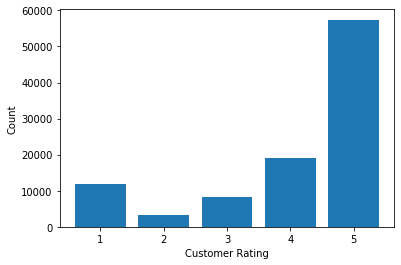

In [48]:
plt.bar(review_df.review_score.value_counts().index, review_df.review_score.value_counts().values)
plt.xlabel('Customer Rating')
plt.ylabel('Count')

## Price vs. Payment

In [49]:
payment_value_df = pd.DataFrame(payment_df.groupby('order_id')['payment_value'].sum())
payment_value_df

,payment_value
order_id,
00010242fe8c5a6d1ba2dd792cb16214,72.19
00018f77f2f0320c557190d7a144bdd3,259.83
000229ec398224ef6ca0657da4fc703e,216.87
00024acbcdf0a6daa1e931b038114c75,25.78
00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...
fffc94f6ce00a00581880bf54a75a037,343.40
fffcd46ef2263f404302a634eb57f7eb,386.53
fffce4705a9662cd70adb13d4a31832d,116.85


In [50]:
price_df = pd.DataFrame(item_df.groupby('order_id')['price'].sum())
price_df

,price
order_id,
00010242fe8c5a6d1ba2dd792cb16214,58.90
00018f77f2f0320c557190d7a144bdd3,239.90
000229ec398224ef6ca0657da4fc703e,199.00
00024acbcdf0a6daa1e931b038114c75,12.99
00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...
fffc94f6ce00a00581880bf54a75a037,299.99
fffcd46ef2263f404302a634eb57f7eb,350.00
fffce4705a9662cd70adb13d4a31832d,99.90


In [51]:
payment_price_df = pd.merge(payment_value_df, price_df, how='left', left_index=True, right_index=True)
payment_price_df['overcharge'] = payment_price_df.payment_value - payment_price_df.price
payment_price_df

,payment_value,price,overcharge
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,72.19,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,259.83,239.90,19.93
000229ec398224ef6ca0657da4fc703e,216.87,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,25.78,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,218.04,199.90,18.14
...,...,...,...
fffc94f6ce00a00581880bf54a75a037,343.40,299.99,43.41
fffcd46ef2263f404302a634eb57f7eb,386.53,350.00,36.53
fffce4705a9662cd70adb13d4a31832d,116.85,99.90,16.95


In [52]:
payment_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, 00010242fe8c5a6d1ba2dd792cb16214 to fffe41c64501cc87c801fd61db3f6244
Data columns (total 3 columns):
payment_value    99440 non-null float64
price            98665 non-null float64
overcharge       98665 non-null float64
dtypes: float64(3)
memory usage: 5.5+ MB


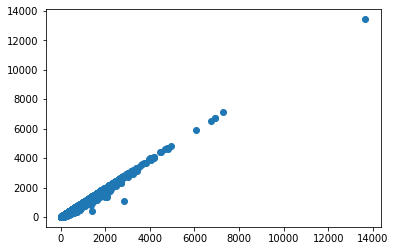

In [53]:
plt.scatter(payment_price_df.payment_value, payment_price_df.price)

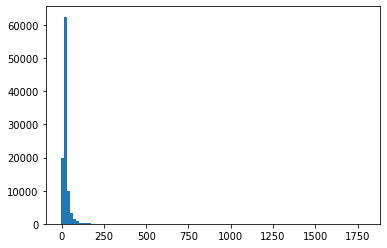

In [54]:
plt.hist(payment_price_df.overcharge, bins=100);

In [55]:
print(payment_price_df.overcharge.min())
print(payment_price_df.overcharge.max())

-5.170000000000016
1794.96


# Feature Engineering

## Delivery Delay

In [56]:
rocpips_df['delay'] = (rocpips_df.order_delivered_customer_date - rocpips_df.order_estimated_delivery_date).dt.days
rocpips_df.drop(['order_delivered_customer_date', 'order_estimated_delivery_date'], axis='columns', inplace=True)
rocpips_df.fillna(rocpips_df.median(), inplace=True)

In [57]:
rocpips_df

,order_id,review_score,review_comment_title,review_comment_message,customer_state,payment_type,payment_installments,payment_value,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_state,delay
0,73fc7af87114b39712e6da79b0a377eb,4,0,0,SP,credit_card,8,397.26,185.0,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-16.0
1,73fc7af87114b39712e6da79b0a377eb,4,0,0,SP,credit_card,8,397.26,185.0,13.63,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-16.0
2,19721d59a9764437477eff0730b48665,5,0,0,RS,credit_card,3,205.26,185.0,20.26,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-18.0
3,efd626e6a12a82d76e456e34093f8356,5,0,0,MG,credit_card,2,202.05,185.0,17.05,esporte_lazer,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-12.0
4,b0bc656fed47584c160f8cff2d7b8bbd,5,0,0,MG,credit_card,1,306.40,135.0,18.20,esporte_lazer,47.0,858.0,1.0,1600.0,30.0,30.0,35.0,SP,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,8c1d27c10cc60cc369a428813bb71350,4,1,1,MG,credit_card,1,108.63,89.9,18.73,moveis_decoracao,50.0,1141.0,2.0,450.0,16.0,16.0,16.0,SP,-14.0
118311,80ba449ea98f8e879a829759b5a66294,5,0,0,GO,credit_card,4,327.25,289.9,37.35,beleza_saude,47.0,696.0,1.0,692.0,15.0,12.0,14.0,PR,-15.0
118312,5fd71cc4eb69ae6f65ac3acfcbc17ab5,5,0,0,RJ,credit_card,2,98.34,79.9,18.44,sinalizacao_e_seguranca,36.0,609.0,2.0,575.0,45.0,21.0,23.0,SP,-14.0
118313,61d5f1dcdf9b023ea7622b65d2362e4f,1,0,1,SP,credit_card,8,767.69,750.0,17.69,relogios_presentes,43.0,381.0,4.0,350.0,20.0,20.0,20.0,SP,-7.0


## Extra Charge

In [58]:
rocpipso_df = pd.merge(rocpips_df, pd.DataFrame(payment_price_df.overcharge), how='left', left_on='order_id', right_index=True)
rocpipso_df

,order_id,review_score,review_comment_title,review_comment_message,customer_state,payment_type,payment_installments,payment_value,price,freight_value,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_state,delay,overcharge
0,73fc7af87114b39712e6da79b0a377eb,4,0,0,SP,credit_card,8,397.26,185.0,13.63,...,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-16.0,27.26
1,73fc7af87114b39712e6da79b0a377eb,4,0,0,SP,credit_card,8,397.26,185.0,13.63,...,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-16.0,27.26
2,19721d59a9764437477eff0730b48665,5,0,0,RS,credit_card,3,205.26,185.0,20.26,...,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-18.0,20.26
3,efd626e6a12a82d76e456e34093f8356,5,0,0,MG,credit_card,2,202.05,185.0,17.05,...,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-12.0,17.05
4,b0bc656fed47584c160f8cff2d7b8bbd,5,0,0,MG,credit_card,1,306.40,135.0,18.20,...,47.0,858.0,1.0,1600.0,30.0,30.0,35.0,SP,-7.0,36.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,8c1d27c10cc60cc369a428813bb71350,4,1,1,MG,credit_card,1,108.63,89.9,18.73,...,50.0,1141.0,2.0,450.0,16.0,16.0,16.0,SP,-14.0,18.73
118311,80ba449ea98f8e879a829759b5a66294,5,0,0,GO,credit_card,4,327.25,289.9,37.35,...,47.0,696.0,1.0,692.0,15.0,12.0,14.0,PR,-15.0,37.35
118312,5fd71cc4eb69ae6f65ac3acfcbc17ab5,5,0,0,RJ,credit_card,2,98.34,79.9,18.44,...,36.0,609.0,2.0,575.0,45.0,21.0,23.0,SP,-14.0,18.44
118313,61d5f1dcdf9b023ea7622b65d2362e4f,1,0,1,SP,credit_card,8,767.69,750.0,17.69,...,43.0,381.0,4.0,350.0,20.0,20.0,20.0,SP,-7.0,17.69


In [59]:
dummies_df = rocpipso_df.drop('order_id', axis='columns')
dummied_df = pd.get_dummies(dummies_df)
target = dummied_df.review_score
df = dummied_df.drop('review_score', axis='columns')
df['review_score'] = target

# Correlation Analysis

In [60]:
from scipy import stats
corr_array=[]
for i in range(df.shape[1]-1):  
    corr_array.append([df.columns[i],
                       np.abs(stats.pearsonr(df[df.columns[i]], df[df.columns[-1]])[0]),
                       stats.pearsonr(df[df.columns[i]], df[df.columns[-1]])[0],
                       stats.pearsonr(df[df.columns[i]], df[df.columns[-1]])[1]])
    
corr_df = pd.DataFrame(corr_array, columns = ['feature', 'abs_corr', 'corr', 'p_value'])
corr_df.sort_values(by='abs_corr', ascending=False, inplace=True)
corr_df.reset_index(drop=True, inplace=True)
corr_df

,feature,abs_corr,corr,p_value
0,review_comment_message,0.292954,-0.292954,0.000000e+00
1,delay,0.217062,-0.217062,0.000000e+00
2,overcharge,0.133149,-0.133149,0.000000e+00
3,payment_value,0.084428,-0.084428,4.498171e-186
4,customer_state_RJ,0.061966,-0.061966,5.408486e-101
...,...,...,...,...
138,product_category_name_la_cuisine,0.000640,-0.000640,8.257624e-01
139,product_category_name_tablets_impressao_imagem,0.000609,0.000609,8.341371e-01
140,seller_state_PI,0.000495,0.000495,8.648774e-01
141,product_category_name_ferramentas_jardim,0.000463,-0.000463,8.735259e-01


In [61]:
rocpipso_df = pd.merge(rocpips_df, pd.DataFrame(payment_price_df.overcharge), how='left', left_on='order_id', right_index=True)
rocpipso_df

,order_id,review_score,review_comment_title,review_comment_message,customer_state,payment_type,payment_installments,payment_value,price,freight_value,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_state,delay,overcharge
0,73fc7af87114b39712e6da79b0a377eb,4,0,0,SP,credit_card,8,397.26,185.0,13.63,...,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-16.0,27.26
1,73fc7af87114b39712e6da79b0a377eb,4,0,0,SP,credit_card,8,397.26,185.0,13.63,...,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-16.0,27.26
2,19721d59a9764437477eff0730b48665,5,0,0,RS,credit_card,3,205.26,185.0,20.26,...,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-18.0,20.26
3,efd626e6a12a82d76e456e34093f8356,5,0,0,MG,credit_card,2,202.05,185.0,17.05,...,42.0,858.0,1.0,1300.0,30.0,30.0,35.0,SP,-12.0,17.05
4,b0bc656fed47584c160f8cff2d7b8bbd,5,0,0,MG,credit_card,1,306.40,135.0,18.20,...,47.0,858.0,1.0,1600.0,30.0,30.0,35.0,SP,-7.0,36.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118310,8c1d27c10cc60cc369a428813bb71350,4,1,1,MG,credit_card,1,108.63,89.9,18.73,...,50.0,1141.0,2.0,450.0,16.0,16.0,16.0,SP,-14.0,18.73
118311,80ba449ea98f8e879a829759b5a66294,5,0,0,GO,credit_card,4,327.25,289.9,37.35,...,47.0,696.0,1.0,692.0,15.0,12.0,14.0,PR,-15.0,37.35
118312,5fd71cc4eb69ae6f65ac3acfcbc17ab5,5,0,0,RJ,credit_card,2,98.34,79.9,18.44,...,36.0,609.0,2.0,575.0,45.0,21.0,23.0,SP,-14.0,18.44
118313,61d5f1dcdf9b023ea7622b65d2362e4f,1,0,1,SP,credit_card,8,767.69,750.0,17.69,...,43.0,381.0,4.0,350.0,20.0,20.0,20.0,SP,-7.0,17.69


In [62]:
dummies_df = rocpipso_df.drop('order_id', axis='columns')
dummied_df = pd.get_dummies(dummies_df)
target = dummied_df.review_score
df = dummied_df.drop('review_score', axis='columns')
df['review_score'] = target

In [63]:
from scipy import stats
corr_array=[]
for i in range(df.shape[1]-1):  
    corr_array.append([df.columns[i],
                       np.abs(stats.pearsonr(df[df.columns[i]], df[df.columns[-1]])[0]),
                       stats.pearsonr(df[df.columns[i]], df[df.columns[-1]])[0],
                       stats.pearsonr(df[df.columns[i]], df[df.columns[-1]])[1]])
    
corr_df = pd.DataFrame(corr_array, columns = ['feature', 'abs_corr', 'corr', 'p_value'])
corr_df.sort_values(by='abs_corr', ascending=False, inplace=True)
corr_df.reset_index(drop=True, inplace=True)
corr_df

,feature,abs_corr,corr,p_value
0,review_comment_message,0.292954,-0.292954,0.000000e+00
1,delay,0.217062,-0.217062,0.000000e+00
2,overcharge,0.133149,-0.133149,0.000000e+00
3,payment_value,0.084428,-0.084428,4.498171e-186
4,customer_state_RJ,0.061966,-0.061966,5.408486e-101
...,...,...,...,...
138,product_category_name_la_cuisine,0.000640,-0.000640,8.257624e-01
139,product_category_name_tablets_impressao_imagem,0.000609,0.000609,8.341371e-01
140,seller_state_PI,0.000495,0.000495,8.648774e-01
141,product_category_name_ferramentas_jardim,0.000463,-0.000463,8.735259e-01


# Logistic Regression

## Variance Inflation Factor

In [64]:
df.loc[df.review_score < 5, 'review_score'] = 0
df.loc[df.review_score == 5, 'review_score'] = 1

# seperate target from features
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

# variance inflation factors
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF_series = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
VIF_series.sort_values(ascending=False, inplace=True)

VIF_df = pd.DataFrame(VIF_series, columns=['vif'])
VIF_df

,vif
seller_state_SP,inf
product_category_name_eletroportateis,inf
product_category_name_alimentos,inf
product_category_name_alimentos_bebidas,inf
product_category_name_artes,inf
...,...
product_photos_qty,1.174266
review_comment_title,1.148413
review_comment_message,1.140944
product_name_lenght,1.118501


In [70]:
VIF_df[VIF_df.vif!=float('inf')]

,vif
payment_value,3.837101
price,3.653994
freight_value,3.260795
product_weight_g,2.865146
overcharge,2.778037
product_height_cm,1.922582
product_width_cm,1.904896
product_length_cm,1.764042
payment_installments,1.405485
product_description_lenght,1.244845


Optimization terminated successfully.
         Current function value: 0.653694
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           review_score   No. Observations:               118315
Model:                          Logit   Df Residuals:                   118299
Method:                           MLE   Df Model:                           15
Date:                Wed, 25 Mar 2020   Pseudo R-squ.:                 0.04667
Time:                        18:20:47   Log-Likelihood:                -77342.
converged:                       True   LL-Null:                       -81128.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.2484      0.006     40.998      0.000       0.237       0.260
payment_value                 -0.0901      0.018     -4.965      0.000      -0.126      -0.055
price                          0.0947      0.015      6.444      0.000       0.066       0.123
freight_value                  0.0707      0.011      6.387      0.000       0.049       0.092
product_weight_g               0.0227      0.010      2.330      0.020       0.004       0.042
overcharge                    -0.2926      0.015    -18.943      0.000      -0.323      -0.262
product_height_cm             -0.0044      0.008     -0.584      0.559      -0.019       0.010
product_width_cm               0.0140      0.008      1.814      0.070      -0.001       0.029
product_length_cm             -0.0270      0.008     -3.592      0.000      -0.042      -0.012
payment_installments          -0.0063      0.006     -0.970      0.332      -0.019       0.006
product_description_lenght     0.0191      0.006      3.027      0.002       0.007       0.031
product_photos_qty             0.0106      0.006      1.711      0.087      -0.002       0.023
review_comment_title           0.0789      0.006     12.382      0.000       0.066       0.091
review_comment_message        -0.3332      0.006    -52.129      0.000      -0.346      -0.321
product_name_lenght           -0.0357      0.006     -5.785      0.000      -0.048      -0.024
delay                         -0.3619      0.007    -52.150      0.000      -0.376      -0.348
==============================================================================================
"""

Text(0.5, 0, 'normalized coefficient')

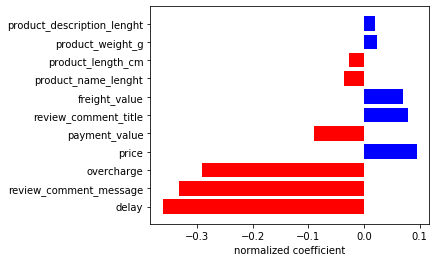

In [71]:
# seperate target from features
X = df[VIF_df[VIF_df.vif!=float('inf')].index]
y = df[df.columns[-1]]

# scale data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

# fit logit function 
import statsmodels.api as sm
X_withconstant = sm.add_constant(X)
logit = sm.Logit(y, X_withconstant).fit()
display(logit.summary()) 

# table of significant coefficinets sorted by absolute value
coef_table = logit.summary().tables[1]
coef_df = pd.DataFrame(data=coef_table.data[1:], columns=coef_table.data[0])
coef_df['coef'] = coef_df['coef'].astype(float)
coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df.drop(0, axis='index', inplace=True)
coefs_by_mag = coef_df.sort_values(by='abs_coef', ascending=False)
coefs_by_mag = coefs_by_mag[coefs_by_mag['P>|z|'] <= 0.05]

# bar chart of feature coefficients
bar_names = coefs_by_mag['']
bar_heights = coefs_by_mag['coef']
bar_colors = np.where(bar_heights>0, 'blue', 'red')
plt.figure(figsize=(5.0, 4.0))
plt.barh(bar_names, bar_heights, color=bar_colors)
plt.xlabel('normalized coefficient')

## L1 Regularization

Optimization terminated successfully.
         Current function value: 0.653811
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           review_score   No. Observations:               118315
Model:                          Logit   Df Residuals:                   118300
Method:                           MLE   Df Model:                           14
Date:                Wed, 25 Mar 2020   Pseudo R-squ.:                 0.04650
Time:                        18:20:55   Log-Likelihood:                -77356.
converged:                       True   LL-Null:                       -81128.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.2484      0.006     41.001      0.000       0.237       0.260
price                          0.0306      0.007      4.270      0.000       0.017       0.045
freight_value                  0.0953      0.010      9.535      0.000       0.076       0.115
product_weight_g               0.0226      0.010      2.319      0.020       0.003       0.042
overcharge                    -0.3473      0.011    -30.976      0.000      -0.369      -0.325
product_height_cm             -0.0041      0.008     -0.537      0.591      -0.019       0.011
product_width_cm               0.0143      0.008      1.848      0.065      -0.001       0.029
product_length_cm             -0.0272      0.008     -3.617      0.000      -0.042      -0.012
payment_installments          -0.0086      0.006     -1.345      0.179      -0.021       0.004
product_description_lenght     0.0189      0.006      2.995      0.003       0.007       0.031
product_photos_qty             0.0109      0.006      1.767      0.077      -0.001       0.023
review_comment_title           0.0785      0.006     12.318      0.000       0.066       0.091
review_comment_message        -0.3328      0.006    -52.079      0.000      -0.345      -0.320
product_name_lenght           -0.0359      0.006     -5.810      0.000      -0.048      -0.024
delay                         -0.3618      0.007    -52.141      0.000      -0.375      -0.348
==============================================================================================
"""

Text(0.5, 0, 'normalized coefficient')

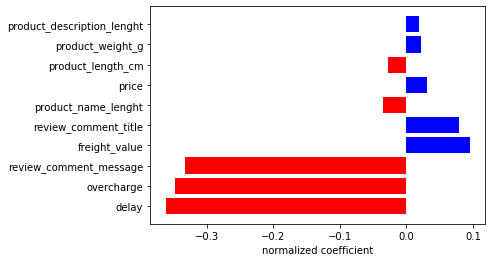

In [72]:
# seperate target from features
X = df[VIF_df[VIF_df.vif!=float('inf')].index].drop('payment_value', axis='columns')
y = df[df.columns[-1]]

# scale data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

# fit logit function 
import statsmodels.api as sm
X_withconstant = sm.add_constant(X)
logit = sm.Logit(y, X_withconstant).fit()
display(logit.summary()) 

# table of significant coefficinets sorted by absolute value
coef_table = logit.summary().tables[1]
coef_df = pd.DataFrame(data=coef_table.data[1:], columns=coef_table.data[0])
coef_df['coef'] = coef_df['coef'].astype(float)
coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df.drop(0, axis='index', inplace=True)
coefs_by_mag = coef_df.sort_values(by='abs_coef', ascending=False)
coefs_by_mag = coefs_by_mag[coefs_by_mag['P>|z|'] <= 0.05]

# bar chart of feature coefficients
plt.barh(coefs_by_mag[''], coefs_by_mag['coef'], color=np.where(coefs_by_mag['coef']>0, 'blue', 'red'))
plt.xlabel('normalized coefficient')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6495666790406812
            Iterations: 56
            Function evaluations: 57
            Gradient evaluations: 56


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           review_score   No. Observations:               118315
Model:                          Logit   Df Residuals:                   118172
Method:                           MLE   Df Model:                          142
Date:                Wed, 25 Mar 2020   Pseudo R-squ.:                 0.05269
Time:                        18:21:04   Log-Likelihood:                -76853.
converged:                       True   LL-Null:                       -81128.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================================================
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                    0.2492      0.008     30.921      0.000       0.233       0.265
review_comment_title                                                     0.0730      0.006     11.292      0.000       0.060       0.086
review_comment_message                                                  -0.3244      0.006    -50.279      0.000      -0.337      -0.312
payment_installments                                                     0.0037      0.007      0.514      0.608      -0.010       0.018
price                                                                    0.0162      0.008      2.120      0.034       0.001       0.031
freight_value                                                            0.1427      0.011     12.900      0.000       0.121       0.164
product_name_lenght                                                     -0.0272      0.006     -4.225      0.000      -0.040      -0.015
product_description_lenght                                               0.0065      0.007      0.956      0.339      -0.007       0.020
product_photos_qty                                                       0.0055      0.007      0.830      0.407      -0.007       0.018
product_weight_g                                                         0.0182      0.010      1.760      0.078      -0.002       0.039
product_length_cm                                                       -0.0233      0.008     -2.881      0.004      -0.039      -0.007
product_height_cm                                                       -0.0263      0.008     -3.113      0.002      -0.043      -0.010
product_width_cm                                                         0.0046      0.008      0.543      0.587      -0.012       0.021
delay                                                                   -0.3677      0.007    -51.683      0.000      -0.382      -0.354
overcharge                                                              -0.3261      0.011    -28.454      0.000      -0.349      -0.304
customer_state_AC                                                       -0.0034   2.62e+04  -1.31e-07      1.000   -5.14e+04    5.14e+04
customer_state_AL                                                       -0.0126   5.78e+04  -2.18e-07      1.000   -1.13e+05    1.13e+05
customer_state_AM                                                       -0.0037   3.53e+04  -1.06e-07      1.000   -6.92e+04    6.92e+04
customer_state_AP                                                       -0.0089   2.47e+04  -3.59e-07      1.000   -4.84e+04    4.84e+04
customer_state_BA                                                       -0.0416   1.69e+05  -2.46e-07      1.000   -3.31e+05    3.31e+05
customer_state_CE                                                       -0.0191   1.06e+05

Text(0.5, 0, 'normalized coefficient')

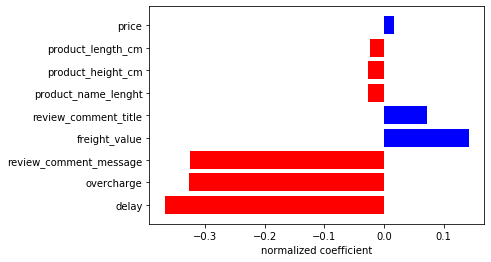

In [73]:
# seperate target from features
X = df[df.columns[:-1]].drop('payment_value', axis='columns')
y = df[df.columns[-1]]

# scale data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

# fit regularized logit function 
import statsmodels.api as sm
X_withconstant = sm.add_constant(X)
logit = sm.Logit(y, X_withconstant).fit_regularized(method='l1')
display(logit.summary()) 

# table of significant coefficinets sorted by absolute value
coef_table = logit.summary().tables[1]
coef_df = pd.DataFrame(data=coef_table.data[1:], columns=coef_table.data[0])
coef_df['coef'] = coef_df['coef'].astype(float)
coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df.drop(0, axis='index', inplace=True)
coefs_by_mag = coef_df.sort_values(by='abs_coef', ascending=False)
coefs_by_mag = coefs_by_mag[coefs_by_mag['P>|z|'] <= 0.05]

# bar chart of feature coefficients
plt.barh(coefs_by_mag[''], coefs_by_mag['coef'], color=np.where(coefs_by_mag['coef']>0, 'blue', 'red'))
plt.xlabel('normalized coefficient')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6494275113187081
            Iterations: 63
            Function evaluations: 64
            Gradient evaluations: 63


Text(0.5, 0, 'normalized coefficient')

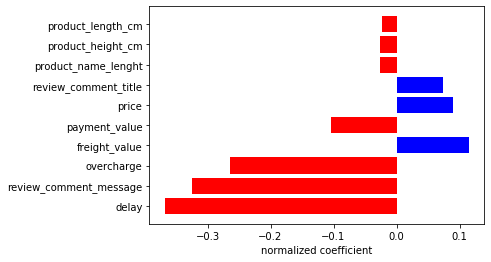

In [74]:
# seperate target from features
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

# scale data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

# fit regularized logit function 
import statsmodels.api as sm
X_withconstant = sm.add_constant(X)
logit = sm.Logit(y, X_withconstant).fit_regularized(method='l1')
logit.summary()

# table of significant coefficinets sorted by absolute value
coef_table = logit.summary().tables[1]
coef_df = pd.DataFrame(data=coef_table.data[1:], columns=coef_table.data[0])
coef_df['coef'] = coef_df['coef'].astype(float)
coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df.drop(0, axis='index', inplace=True)
coefs_by_mag = coef_df.sort_values(by='abs_coef', ascending=False)
coefs_by_mag = coefs_by_mag[coefs_by_mag['P>|z|'] <= 0.05]

# bar chart of feature coefficients
plt.barh(coefs_by_mag[''], coefs_by_mag['coef'], color=np.where(coefs_by_mag['coef']>0, 'blue', 'red'))
plt.xlabel('normalized coefficient')